## 불균형 데이터셋에 대한 웨이퍼 불량식별을 위한 CNN
- 데이터 전처리
    - Data Augmentaion
    - 불량 클래스
        - Center
        - Donut
        - Local
        - Edge-Loc
        - Edge-Ring
        - Scratch
        - Random
        - Near-Full
        - None

### 데이터 확인사항
- waferMap 사이즈를 확인하여 추후 개발할 신경망 모델의 224x224 사이즈에 맞게 resizing 작업이 필요할 것으로 예상됨
- augmentaion 작업과 resizing 작업이 한 번에 해결될 수 있도록 전처리하는 것이 좋을 듯

In [59]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import pickle

In [2]:
wm811k = pd.read_pickle('./data/LSWMD.pkl')

In [3]:
wm811k.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
wm811k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [5]:
# 불필요 컬럼 제거
wm811k = wm811k.drop(['waferIndex'], axis = 1)
wm811k.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]]


In [6]:
# wafermap size 확인 및 컬럼 추가
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1

In [7]:
wm811k['waferMapDim']=wm811k['waferMap'].apply(find_dim)
wm811k.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [8]:
# 불량 클래스 확인 및 학습/검증/테스트 데이터 셋 확인
wm811k['failureNum']=wm811k['failureType']
wm811k['trainTestNum']=wm811k['trianTestLabel']
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
wm811k=wm811k.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
wm811k.head()

C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\pandas\core\array_algos\replace.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0


In [9]:
wm811k['trianTestLabel'].apply(lambda x: str(x)).value_counts()

[]                638507
[['Test']]        118595
[['Training']]     54355
Name: trianTestLabel, dtype: int64

In [10]:
wm811k['trainTestNum'].apply(lambda x: str(x)).value_counts()

[]    638507
1     118595
0      54355
Name: trainTestNum, dtype: int64

In [11]:
wm811k_train = wm811k.query("trainTestNum == 0")

In [12]:
wm811k_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54355 entries, 0 to 791476
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   waferMap        54355 non-null  object 
 1   dieSize         54355 non-null  float64
 2   lotName         54355 non-null  object 
 3   trianTestLabel  54355 non-null  object 
 4   failureType     54355 non-null  object 
 5   waferMapDim     54355 non-null  object 
 6   failureNum      54355 non-null  object 
 7   trainTestNum    54355 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.7+ MB


In [13]:
# 학습 데이터 내 불량 클래스 개수 확인
wm811k_train['failureNum'].value_counts()

8    36730
3     8554
0     3462
2     2417
4     1620
5      609
6      500
1      409
7       54
Name: failureNum, dtype: int64

### waferMap size 확인
- data print 결과 빈 부분은 0, 정상 pixel은 1, 불량 pixel은 2로 표현되어있는 듯
    - input shape 맞출 때 0으로 padding 주듯이 채우면 될 듯
- 예상 전처리 과정 : 기존 데이터에 data augmentaion 적용 $ \rightarrow $ 변형 데이터에 224x224 size zero_padding $ \rightarrow $ input data

In [14]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [15]:
# 데이터 형태 출력
# for i in range(len(wm811k.iloc[0]['waferMap'])):
#     print(wm811k.iloc[0]['waferMap'][i])

In [16]:
# 학습 데이터 내 불량 클래스 개수 확인
wm811k_train['failureNum'].value_counts()

8    36730
3     8554
0     3462
2     2417
4     1620
5      609
6      500
1      409
7       54
Name: failureNum, dtype: int64

### Augmentation 구현
- 기법 별로 함수 작성
- 비율 개수만큼 sampling
- sampling 데이터에 작성한 기법별 함수 적용
- waferMapDim 확인 / waferMap 이미지 부분 잘리거나 한 부분 없게끔 적용되게 확인 : 미리 padding 주기?
- data concat

- 10도 회전
    - 참고 : https://076923.github.io/posts/Python-opencv-6/

In [17]:
def test_rotation_10_degree(data_img):
    height, width = data_img.shape
    # positive for anti-clockwise and negative for clockwise
    rotation_10_degree_img = cv2.getRotationMatrix2D((width/2, height/2), 10, 1) # 중심점, 각도, 배율
    dst = cv2.warpAffine(data_img, rotation_10_degree_img, (width,height))
    return dst

In [18]:
def test_rotation_minus_10_degree(data_img):
    height, width = data_img.shape
    # positive for anti-clockwise and negative for clockwise
    rotation_10_degree_img = cv2.getRotationMatrix2D((width/2, height/2), -10, 1) # 중심점, 각도, 배율
    dst = cv2.warpAffine(data_img, rotation_10_degree_img, (width,height))
    return dst

In [19]:
# 회전 변환 다른 라이브러리 활용하는 방법 참고
# from scipy.ndimage.interpolation import rotate
# rotated = rotate(test_wafermap.iloc[3]["waferMap"], angle=10,reshape=False)
# plt.imshow(rotated)
# plt.show()

- 좌우 대칭 및 너비 이동(horizontal flipping and width shift)
    - cv2.flip : https://crmn.tistory.com/54
        - flip_img = cv2.flip(data_img, 1) # 1:좌우반전, 0:상하반전 
    - translate : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=vps32&logNo=221762189533
        - width shift
        - height shift

In [20]:
def test_translate(data_img):
    height, width = data_img.shape
    # random ~ 범위 지정하여 함수 실행 시 마다 무작위로 평행이동 정도 부여하게끔 수정 필요
    # 224x224 size 안에서 이동하도록 코딩 필요
    translate_matrix = np.float32([[1,0,10], [0,1,5]]) # 세로 10, 가로 5 만큼 평행 이동 
    dst = cv2.warpAffine(data_img, translate_matrix, (width,height))
    return dst

- 전단 범위(shearing range)
    - https://www.thepythoncode.com/article/image-transformations-using-opencv-in-python
    - https://stackoverflow.com/questions/57881430/how-could-i-implement-a-centered-shear-an-image-with-opencv

In [21]:
def test_shearing(data_img):
    height, width = data_img.shape
    # random ~ 범위 지정하여 함수 실행 시 마다 x축, y축 shearing 정도 부여하게끔 수정 필요
    shearing_matrix = np.float32([[1, 0.5, 0],    # shearing applied to y-axis
             	                  [0, 1  , 0],    # M = np.float32([[1,   0, 0],
            	                  [0, 0  , 1]])   #             	[0.5, 1, 0],
                                                  #             	[0,   0, 1]])  
    # apply a perspective transformation to the image                
    dst = cv2.warpPerspective(data_img, shearing_matrix, (int(width*1.5),int(height*1.5)))                      
    # 변형 이미지 중심 보정?
    return dst

- 채널이동 및 확대 축소(channel shift and zooming)
    - 단일 채널 이미지라 channel shift는 적용 안 될 것 같음
    - zoom : https://076923.github.io/posts/Python-opencv-7/
    - cv2.resize 함수 참고
        - 참고 : https://seokii.tistory.com/14

In [22]:
def test_zoom(data_img):
    height, width = data_img.shape
    # 2배 확대 이미지 / 가로 세로 값이 조건에 맞으면 dstsize로 값 부여하여 세밀 조정 가능
    # 224x224 size 안에서 2배 확대 가능하도록 코딩 필요
    dst = cv2.pyrUp(data_img, dstsize=(width * 2, height * 2), borderType=cv2.BORDER_DEFAULT)
    return dst

- test

In [23]:
test_wafermap = wm811k_train.query("failureNum == 6").sample(n=5)

In [24]:
test_wafermap.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
262968,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4811.0,lot16299,[[Training]],[[Scratch]],"(87, 71)",6,0
389812,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3878.0,lot23391,[[Training]],[[Scratch]],"(88, 56)",6,0
366023,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15545.0,lot21895,[[Training]],[[Scratch]],"(135, 146)",6,0
13741,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,...",741.0,lot2137,[[Training]],[[Scratch]],"(33, 29)",6,0
365027,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1338.0,lot21853,[[Training]],[[Scratch]],"(40, 43)",6,0


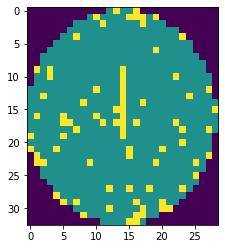

In [25]:
test_img = test_wafermap.iloc[3]["waferMap"]
plt.imshow(test_img)
plt.show()

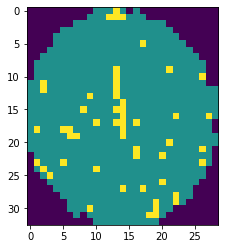

In [26]:
plt.imshow(test_rotation_10_degree(test_img))
plt.show()

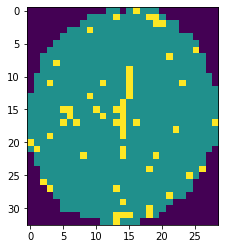

In [27]:
plt.imshow(test_rotation_minus_10_degree(test_img))
plt.show()

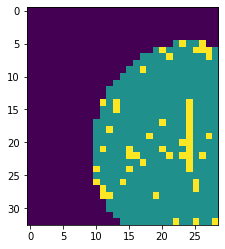

In [28]:
plt.imshow(test_translate(test_img))
plt.show()

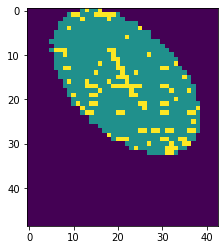

In [29]:
plt.imshow(test_shearing(test_img))
plt.show()

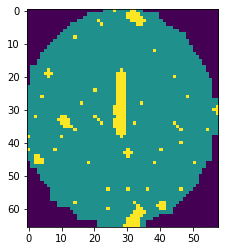

In [30]:
plt.imshow(test_zoom(test_img))
plt.show()

### Input size에 맞게 zero-padding
- 참고 : https://webnautes.tistory.com/1652-

In [31]:
def zero_padding(data_img, set_size):
    height, width = data_img.shape
    
    if max(height, width) > set_size:
        return data_img
    
    delta_width = set_size - width
    delta_height = set_size - height
    top, bottom = delta_height//2, delta_height-(delta_height//2)
    left, right = delta_width//2, delta_width-(delta_width//2)
    
    padded_img = cv2.copyMakeBorder(data_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
    return padded_img

### pad 이후 전처리 / 전처리 이후 pad 비교

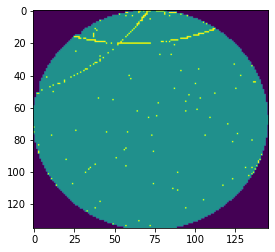

In [32]:
# 원본
test_origin = test_wafermap.iloc[2]["waferMap"]
plt.imshow(test_origin)
plt.show()

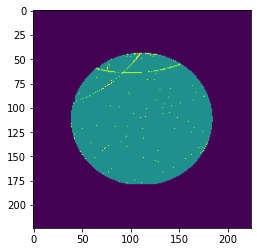

In [33]:
pad_origin = zero_padding(test_origin, 224)
plt.imshow(pad_origin)
plt.show()

- 회전의 경우 pad 이후 회전과 회전 이후 pad 가 비슷해보임

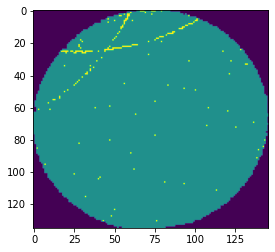

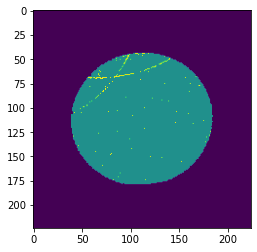

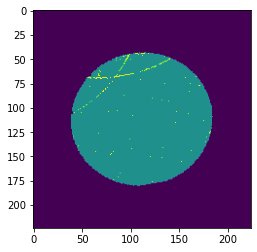

In [34]:
# 10도 회전 : 
degree_10 = test_rotation_10_degree(test_origin)
plt.imshow(degree_10)
plt.show()

pad_10_degree = zero_padding(degree_10, 224)
plt.imshow(pad_10_degree)
plt.show()

degree_10_pad_origin = test_rotation_10_degree(pad_origin)
plt.imshow(degree_10_pad_origin)
plt.show()

- 평행이동 : 이동 이후 wafer 모양이 잘리는 경우를 감안하면 pad 이후 이동하는 것이 나아보임

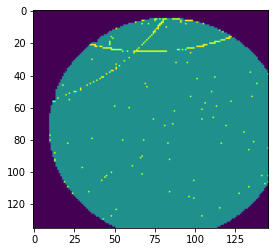

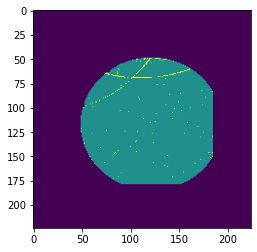

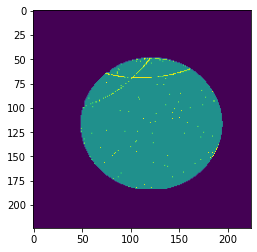

In [35]:
translated =  test_translate(test_origin)
plt.imshow(translated)
plt.show()

pad_translated = zero_padding(translated, 224)
plt.imshow(pad_translated)
plt.show()

translate_pad_origin = test_translate(pad_origin)
plt.imshow(translate_pad_origin)
plt.show()

In [36]:
translate_pad_origin.shape

(224, 224)

- shearing : 잘리지 않을 범위 내에서 shearing 이후 pad 하는 것이 나을 듯
    - shearing 정도에 따라 translate와 마찬가지로 wafer 모양이 잘릴 가능성이 있음
    - pad 이후 shearing 시 shape이 변함

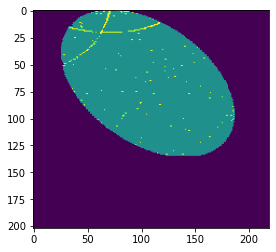

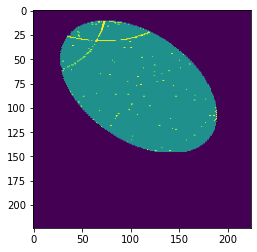

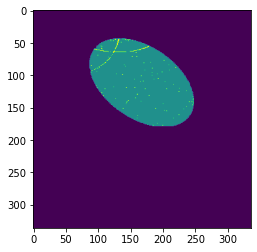

In [37]:
sheared = test_shearing(test_origin)
plt.imshow(sheared)
plt.show()

pad_sheared = zero_padding(sheared, 224)
plt.imshow(pad_sheared)
plt.show()

sheared_pad_origin = test_shearing(pad_origin)
plt.imshow(sheared_pad_origin)
plt.show()

In [38]:
sheared_pad_origin.shape

(336, 336)

- zooming : pad 이후 zoom할 경우 448x448 사이즈 이미지가 생성되므로 zoom 이후 pad 적용

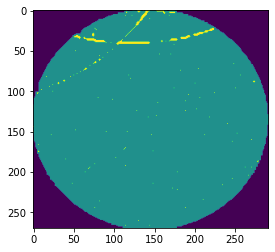

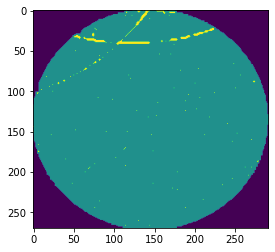

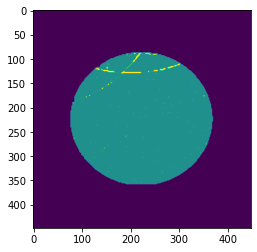

In [39]:
zoomed = test_zoom(test_origin)
plt.imshow(zoomed)
plt.show()

pad_zoomed = zero_padding(zoomed, 224)
plt.imshow(pad_zoomed)
plt.show()

zoom_pad_origin = test_zoom(pad_origin)
plt.imshow(zoom_pad_origin)
plt.show()

### augmentaion 함수별 random 요소 추가 및 padding 함수 추가
- rotation : 회전 변환 이후 padding
- translate : padding 이후 평행이동, dsize ~ 224로 출력
- shearing : shearing 정도에 random 요소 추가, dsize ~ 224로 출력 

In [40]:
def rotation_10_degree(data_img):
    height, width = data_img.shape
    # positive for anti-clockwise and negative for clockwise
    rotation_10_degree_img = cv2.getRotationMatrix2D((width/2, height/2), 10, 1) # 중심점, 각도, 배율
    dst = cv2.warpAffine(data_img, rotation_10_degree_img, (width,height))
    padded_dst = zero_padding(dst, 224)
    return padded_dst

In [41]:
def rotation_minus_10_degree(data_img):
    height, width = data_img.shape
    # positive for anti-clockwise and negative for clockwise
    rotation_10_degree_img = cv2.getRotationMatrix2D((width/2, height/2), -10, 1) # 중심점, 각도, 배율
    dst = cv2.warpAffine(data_img, rotation_10_degree_img, (width,height))
    padded_dst = zero_padding(dst, 224)
    return padded_dst

In [42]:
def translate(data_img):
    padded_img = zero_padding(data_img, 224)
    x_translate = random.randrange(-20, 21)
    y_translate = random.randrange(-20, 21)
    translate_matrix = np.float32([[1, 0, y_translate],  # 세로 평행이동
                                   [0, 1, x_translate]]) # 가로 평행이동 
    dst = cv2.warpAffine(padded_img, translate_matrix, (224,224))  # (src, matrix, dsize)
    return dst

In [43]:
def filping(data_img):
    padded_img = zero_padding(data_img, 224)
    dst = cv2.flip(padded_img, random.choice([0, 1])) # 0:상하 반전, 1:좌우 반전 
    return dst

In [44]:
def shearing(data_img):    
    x_shearing = random.random()
    y_shearing = random.random()
    shearing_matrix = np.float32([[1,          x_shearing, 0],
             	                  [y_shearing, 1,          0],
            	                  [0,          0  ,        1]])           
    dst = cv2.warpPerspective(data_img, shearing_matrix, (224, 224)) # warpPerspective(src, matrix, dsize~(width, height))
    return dst

In [45]:
def resizing(data_img):
    scale_list = [0.5, 0.6, 0.7, 0.8, 1.05] # scale 이후 224 size 넘는 경우 있어서 데이터 확인 후 수동 조정
    dst = cv2.resize(data_img, dsize=(0,0), fx=random.choice(scale_list), fy=random.choice(scale_list), interpolation=cv2.INTER_LINEAR)    
    padded_img = zero_padding(dst, 224)
    return padded_img

### Data-Augmentaion - 클래스별로 10,000개 / 논문 Augmentation 기법 적용
- 10도 회전 : 20%
- 좌우 대칭 및 너비 이동(horizontal flipping and width shift) : 20%
- 높이 이동(height shfit) : 15%
- 전단 범위(shearing range) : 10%
- 채널이동 및 확대 축소(channel shift and zooming) : 10%
- 75%밖에 안 되는 듯 : 증량 비율 수정

In [46]:
# None(8): 36,730 중 10,000 개 Sampling
# 참고 : https://rfriend.tistory.com/602
wm811k_new_train_class_None = wm811k_train.query("failureNum == 8").sample(n=10000, random_state=2022)
wm811k_new_train_class_None["waferMap_augmentation"] = wm811k_new_train_class_None["waferMap"].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_None['waferMap_augmentation_Dim']=wm811k_new_train_class_None['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_None.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 749336 to 244652
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   10000 non-null  object 
 1   dieSize                    10000 non-null  float64
 2   lotName                    10000 non-null  object 
 3   trianTestLabel             10000 non-null  object 
 4   failureType                10000 non-null  object 
 5   waferMapDim                10000 non-null  object 
 6   failureNum                 10000 non-null  object 
 7   trainTestNum               10000 non-null  object 
 8   waferMap_augmentation      10000 non-null  object 
 9   waferMap_augmentation_Dim  10000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 859.4+ KB


In [47]:
wm811k_new_train_class_None['waferMap_augmentation_Dim'].apply(lambda x: str(x)).value_counts()

(224, 224)    10000
Name: waferMap_augmentation_Dim, dtype: int64

In [48]:
# Edge-Ring(3) 현 보유 8,554개 / 1,446개 augmentation 필요
wm811k_new_train_class_Edge_Ring = wm811k_train.query("failureNum == 3")
wm811k_new_train_class_Edge_Ring["waferMap_augmentation"] = wm811k_new_train_class_Edge_Ring['waferMap'].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_Edge_Ring['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Ring['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_Edge_Ring.info()

# +10도 회전 : 10% - 144개
wm811k_new_train_class_Edge_Ring_10 = wm811k_new_train_class_Edge_Ring.sample(n=144, random_state=2022)
wm811k_new_train_class_Edge_Ring_10["waferMap_augmentation"] = wm811k_new_train_class_Edge_Ring_10["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Edge_Ring_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Ring_10['waferMap_augmentation'].apply(find_dim)

# -10도 회전 : 10% - 144개
wm811k_new_train_class_Edge_Ring_minus_10 = wm811k_new_train_class_Edge_Ring.sample(n=144, random_state=2022)
wm811k_new_train_class_Edge_Ring_minus_10["waferMap_augmentation"] = wm811k_new_train_class_Edge_Ring_minus_10["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Edge_Ring_minus_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Ring_minus_10['waferMap_augmentation'].apply(find_dim)

# 좌우 대칭 : 20%  - 288개
wm811k_new_train_class_Edge_Ring_flip = wm811k_new_train_class_Edge_Ring.sample(n=288, random_state=2022)
wm811k_new_train_class_Edge_Ring_flip["waferMap_augmentation"] = wm811k_new_train_class_Edge_Ring_flip["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Edge_Ring_flip['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Ring_flip['waferMap_augmentation'].apply(find_dim)

# 평행 이동 : 30% - 432개
wm811k_new_train_class_Edge_Ring_translate = wm811k_new_train_class_Edge_Ring.sample(n=432, random_state=2022)
wm811k_new_train_class_Edge_Ring_translate["waferMap_augmentation"] = wm811k_new_train_class_Edge_Ring_translate["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Edge_Ring_translate['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Ring_translate['waferMap_augmentation'].apply(find_dim)

# 전단 범위(shearing range) : 10% - 144개
wm811k_new_train_class_Edge_Ring_shearing = wm811k_new_train_class_Edge_Ring.sample(n=144, random_state=2022)
wm811k_new_train_class_Edge_Ring_shearing["waferMap_augmentation"] = wm811k_new_train_class_Edge_Ring_shearing["waferMap"].apply(lambda x: shearing(x))
wm811k_new_train_class_Edge_Ring_shearing['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Ring_shearing['waferMap_augmentation'].apply(find_dim)

# 확대 : 20% - 294개
wm811k_new_train_class_Edge_Ring_resize = wm811k_new_train_class_Edge_Ring.sample(n=294, random_state=2022)
wm811k_new_train_class_Edge_Ring_resize["waferMap_augmentation"] = wm811k_new_train_class_Edge_Ring_resize["waferMap"].apply(lambda x: resizing(x))
wm811k_new_train_class_Edge_Ring_resize['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Ring_resize['waferMap_augmentation'].apply(find_dim)

# concat
wm811k_new_train_class_Edge_Ring_augmentation = pd.concat([wm811k_new_train_class_Edge_Ring,
                                                           wm811k_new_train_class_Edge_Ring_10,
                                                           wm811k_new_train_class_Edge_Ring_minus_10,
                                                           wm811k_new_train_class_Edge_Ring_flip,
                                                           wm811k_new_train_class_Edge_Ring_translate,
                                                           wm811k_new_train_class_Edge_Ring_shearing,
                                                           wm811k_new_train_class_Edge_Ring_resize
                                                          ])
wm811k_new_train_class_Edge_Ring_augmentation.info()

C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8554 entries, 100 to 786313
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   8554 non-null   object 
 1   dieSize                    8554 non-null   float64
 2   lotName                    8554 non-null   object 
 3   trianTestLabel             8554 non-null   object 
 4   failureType                8554 non-null   object 
 5   waferMapDim                8554 non-null   object 
 6   failureNum                 8554 non-null   object 
 7   trainTestNum               8554 non-null   object 
 8   waferMap_augmentation      8554 non-null   object 
 9   waferMap_augmentation_Dim  8554 non-null   object 
dtypes: float64(1), object(9)
memory usage: 735.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 100 to 199660
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dty

In [49]:
# Center(0) 현 보유 3,462개 / 6,538개 augmentation 필요
wm811k_new_train_class_Center = wm811k_train.query("failureNum == 0")
wm811k_new_train_class_Center["waferMap_augmentation"] = wm811k_new_train_class_Center['waferMap'].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_Center['waferMap_augmentation_Dim']=wm811k_new_train_class_Center['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_Center.info()

# +10도 회전 : 10% - 654개
wm811k_new_train_class_Center_10 = wm811k_new_train_class_Center.sample(n=654, random_state=2022)
wm811k_new_train_class_Center_10["waferMap_augmentation"] = wm811k_new_train_class_Center_10["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Center_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Center_10['waferMap_augmentation'].apply(find_dim)

# -10도 회전 : 10% - 654개
wm811k_new_train_class_Center_minus_10 = wm811k_new_train_class_Center.sample(n=654, random_state=2022)
wm811k_new_train_class_Center_minus_10["waferMap_augmentation"] = wm811k_new_train_class_Center_minus_10["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Center_minus_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Center_minus_10['waferMap_augmentation'].apply(find_dim)

# 좌우 대칭 : 20%  - 1308개
wm811k_new_train_class_Center_flip = wm811k_new_train_class_Center.sample(n=1308, random_state=2022)
wm811k_new_train_class_Center_flip["waferMap_augmentation"] = wm811k_new_train_class_Center_flip["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Center_flip['waferMap_augmentation_Dim']=wm811k_new_train_class_Center_flip['waferMap_augmentation'].apply(find_dim)

# 평행 이동 : 30%  - 1962개
wm811k_new_train_class_Center_translate = wm811k_new_train_class_Center.sample(n=1962, random_state=2022)
wm811k_new_train_class_Center_translate["waferMap_augmentation"] = wm811k_new_train_class_Center_translate["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Center_translate['waferMap_augmentation_Dim']=wm811k_new_train_class_Center_translate['waferMap_augmentation'].apply(find_dim)

# 전단 범위(shearing range) : 10% - 652개
wm811k_new_train_class_Center_shearing = wm811k_new_train_class_Center.sample(n=652, random_state=2022)
wm811k_new_train_class_Center_shearing["waferMap_augmentation"] = wm811k_new_train_class_Center_shearing["waferMap"].apply(lambda x: shearing(x))
wm811k_new_train_class_Center_shearing['waferMap_augmentation_Dim']=wm811k_new_train_class_Center_shearing['waferMap_augmentation'].apply(find_dim)

# 확대 : 20% - 1308개
wm811k_new_train_class_Center_resize = wm811k_new_train_class_Center.sample(n=1308, random_state=2022)
wm811k_new_train_class_Center_resize["waferMap_augmentation"] = wm811k_new_train_class_Center_resize["waferMap"].apply(lambda x: resizing(x))
wm811k_new_train_class_Center_resize['waferMap_augmentation_Dim']=wm811k_new_train_class_Center_resize['waferMap_augmentation'].apply(find_dim)

# concat
wm811k_new_train_class_Center_augmentation = pd.concat([wm811k_new_train_class_Center,
                                                        wm811k_new_train_class_Center_10,
                                                        wm811k_new_train_class_Center_minus_10,
                                                        wm811k_new_train_class_Center_flip,
                                                        wm811k_new_train_class_Center_translate,
                                                        wm811k_new_train_class_Center_shearing,
                                                        wm811k_new_train_class_Center_resize
                                                       ])
wm811k_new_train_class_Center_augmentation.info()

C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3462 entries, 44 to 785245
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   3462 non-null   object 
 1   dieSize                    3462 non-null   float64
 2   lotName                    3462 non-null   object 
 3   trianTestLabel             3462 non-null   object 
 4   failureType                3462 non-null   object 
 5   waferMapDim                3462 non-null   object 
 6   failureNum                 3462 non-null   object 
 7   trainTestNum               3462 non-null   object 
 8   waferMap_augmentation      3462 non-null   object 
 9   waferMap_augmentation_Dim  3462 non-null   object 
dtypes: float64(1), object(9)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 44 to 360911
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype

In [50]:
# Edge-Loc(2) 현 보유 2,417개 / 7,583개 augmentation 필요
wm811k_new_train_class_Edge_Loc = wm811k_train.query("failureNum == 2")
wm811k_new_train_class_Edge_Loc["waferMap_augmentation"] = wm811k_new_train_class_Edge_Loc['waferMap'].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_Edge_Loc['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Loc['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_Edge_Loc.info()

# +10도 회전 : 10% - 758개
wm811k_new_train_class_Edge_Loc_10 = wm811k_new_train_class_Edge_Loc.sample(n=758, random_state=2022)
wm811k_new_train_class_Edge_Loc_10["waferMap_augmentation"] = wm811k_new_train_class_Edge_Loc_10["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Edge_Loc_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Loc_10['waferMap_augmentation'].apply(find_dim)

# -10도 회전 : 10% - 758개
wm811k_new_train_class_Edge_Loc_minus_10 = wm811k_new_train_class_Edge_Loc.sample(n=758, random_state=2022)
wm811k_new_train_class_Edge_Loc_minus_10["waferMap_augmentation"] = wm811k_new_train_class_Edge_Loc_minus_10["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Edge_Loc_minus_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Loc_minus_10['waferMap_augmentation'].apply(find_dim)

# 좌우 대칭 : 20% - 1517개
wm811k_new_train_class_Edge_Loc_flip = wm811k_new_train_class_Edge_Loc.sample(n=1517, random_state=2022)
wm811k_new_train_class_Edge_Loc_flip["waferMap_augmentation"] = wm811k_new_train_class_Edge_Loc_flip["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Edge_Loc_flip['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Loc_flip['waferMap_augmentation'].apply(find_dim)

# 평행 이동 : 30% - 2275개
wm811k_new_train_class_Edge_Loc_translate = wm811k_new_train_class_Edge_Loc.sample(n=2275, random_state=2022)
wm811k_new_train_class_Edge_Loc_translate["waferMap_augmentation"] = wm811k_new_train_class_Edge_Loc_translate["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Edge_Loc_translate['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Loc_translate['waferMap_augmentation'].apply(find_dim)

# 전단 범위(shearing range) : 10% - 758개
wm811k_new_train_class_Edge_Loc_shearing = wm811k_new_train_class_Edge_Loc.sample(n=758, random_state=2022)
wm811k_new_train_class_Edge_Loc_shearing["waferMap_augmentation"] = wm811k_new_train_class_Edge_Loc_shearing["waferMap"].apply(lambda x: shearing(x))
wm811k_new_train_class_Edge_Loc_shearing['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Loc_shearing['waferMap_augmentation'].apply(find_dim)

# 확대 : 20% - 1517개
wm811k_new_train_class_Edge_Loc_resize = wm811k_new_train_class_Edge_Loc.sample(n=1517, random_state=2022)
wm811k_new_train_class_Edge_Loc_resize["waferMap_augmentation"] = wm811k_new_train_class_Edge_Loc_resize["waferMap"].apply(lambda x: resizing(x))
wm811k_new_train_class_Edge_Loc_resize['waferMap_augmentation_Dim']=wm811k_new_train_class_Edge_Loc_resize['waferMap_augmentation'].apply(find_dim)

# concat
wm811k_new_train_class_Edge_Loc_augmentation = pd.concat([wm811k_new_train_class_Edge_Loc,
                                                          wm811k_new_train_class_Edge_Loc_10,
                                                          wm811k_new_train_class_Edge_Loc_minus_10,
                                                          wm811k_new_train_class_Edge_Loc_flip,
                                                          wm811k_new_train_class_Edge_Loc_translate,
                                                          wm811k_new_train_class_Edge_Loc_shearing,
                                                          wm811k_new_train_class_Edge_Loc_resize
                                                         ])
wm811k_new_train_class_Edge_Loc_augmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2417 entries, 36 to 791230
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   2417 non-null   object 
 1   dieSize                    2417 non-null   float64
 2   lotName                    2417 non-null   object 
 3   trianTestLabel             2417 non-null   object 
 4   failureType                2417 non-null   object 
 5   waferMapDim                2417 non-null   object 
 6   failureNum                 2417 non-null   object 
 7   trainTestNum               2417 non-null   object 
 8   waferMap_augmentation      2417 non-null   object 
 9   waferMap_augmentation_Dim  2417 non-null   object 
dtypes: float64(1), object(9)
memory usage: 207.7+ KB


C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 36 to 417018
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   10000 non-null  object 
 1   dieSize                    10000 non-null  float64
 2   lotName                    10000 non-null  object 
 3   trianTestLabel             10000 non-null  object 
 4   failureType                10000 non-null  object 
 5   waferMapDim                10000 non-null  object 
 6   failureNum                 10000 non-null  object 
 7   trainTestNum               10000 non-null  object 
 8   waferMap_augmentation      10000 non-null  object 
 9   waferMap_augmentation_Dim  10000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 859.4+ KB


In [51]:
# Loc(4) 현 보유 1,620개 / 8,380개 augmentation 필요
wm811k_new_train_class_Loc = wm811k_train.query("failureNum == 4")
wm811k_new_train_class_Loc["waferMap_augmentation"] = wm811k_new_train_class_Loc['waferMap'].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_Loc['waferMap_augmentation_Dim']=wm811k_new_train_class_Loc['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_Loc.info()

# +10도 회전 : 10% - 838개
wm811k_new_train_class_Loc_10 = wm811k_new_train_class_Loc.sample(n=838, random_state=2022)
wm811k_new_train_class_Loc_10["waferMap_augmentation"] = wm811k_new_train_class_Loc_10["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Loc_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Loc_10['waferMap_augmentation'].apply(find_dim)

# -10도 회전 : 10% - 838개
wm811k_new_train_class_Loc_minus_10 = wm811k_new_train_class_Loc.sample(n=838, random_state=2022)
wm811k_new_train_class_Loc_minus_10["waferMap_augmentation"] = wm811k_new_train_class_Loc_minus_10["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Loc_minus_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Loc_minus_10['waferMap_augmentation'].apply(find_dim)

# 중간 concat
wm811k_new_train_class_Loc_patial_concat = pd.concat([wm811k_new_train_class_Loc,
                                                      wm811k_new_train_class_Loc_10,
                                                      wm811k_new_train_class_Loc_minus_10
                                                     ])
wm811k_new_train_class_Loc_patial_concat.info()

# 좌우 대칭 : 20%  - "1676개"
wm811k_new_train_class_Loc_flip = wm811k_new_train_class_Loc_patial_concat.sample(n=1676, random_state=2022)
wm811k_new_train_class_Loc_flip["waferMap_augmentation"] = wm811k_new_train_class_Loc_flip["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Loc_flip['waferMap_augmentation_Dim']=wm811k_new_train_class_Loc_flip['waferMap_augmentation'].apply(find_dim)

# 평행 이동 : 30%  - "2514개"
wm811k_new_train_class_Loc_translate = wm811k_new_train_class_Loc_patial_concat.sample(n=2514, random_state=2022)
wm811k_new_train_class_Loc_translate["waferMap_augmentation"] = wm811k_new_train_class_Loc_translate["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Loc_translate['waferMap_augmentation_Dim']=wm811k_new_train_class_Loc_translate['waferMap_augmentation'].apply(find_dim)

# 전단 범위(shearing range) : 10% - 838개
wm811k_new_train_class_Loc_shearing = wm811k_new_train_class_Loc.sample(n=838, random_state=2022)
wm811k_new_train_class_Loc_shearing["waferMap_augmentation"] = wm811k_new_train_class_Loc_shearing["waferMap"].apply(lambda x: shearing(x))
wm811k_new_train_class_Loc_shearing['waferMap_augmentation_Dim']=wm811k_new_train_class_Loc_shearing['waferMap_augmentation'].apply(find_dim)

# 확대 : 20% - "1676개"
wm811k_new_train_class_Loc_resize = wm811k_new_train_class_Loc_patial_concat.sample(n=1676, random_state=2022)
wm811k_new_train_class_Loc_resize["waferMap_augmentation"] = wm811k_new_train_class_Loc_resize["waferMap"].apply(lambda x: resizing(x))
wm811k_new_train_class_Loc_resize['waferMap_augmentation_Dim']=wm811k_new_train_class_Loc_resize['waferMap_augmentation'].apply(find_dim)

# concat
wm811k_new_train_class_Loc_augmentation = pd.concat([wm811k_new_train_class_Loc,
                                                      wm811k_new_train_class_Loc_10,
                                                      wm811k_new_train_class_Loc_minus_10,
                                                      wm811k_new_train_class_Loc_flip,
                                                      wm811k_new_train_class_Loc_translate,
                                                      wm811k_new_train_class_Loc_shearing,
                                                      wm811k_new_train_class_Loc_resize
                                                     ])
wm811k_new_train_class_Loc_augmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1620 entries, 19 to 791433
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   1620 non-null   object 
 1   dieSize                    1620 non-null   float64
 2   lotName                    1620 non-null   object 
 3   trianTestLabel             1620 non-null   object 
 4   failureType                1620 non-null   object 
 5   waferMapDim                1620 non-null   object 
 6   failureNum                 1620 non-null   object 
 7   trainTestNum               1620 non-null   object 
 8   waferMap_augmentation      1620 non-null   object 
 9   waferMap_augmentation_Dim  1620 non-null   object 
dtypes: float64(1), object(9)
memory usage: 139.2+ KB


C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3296 entries, 19 to 12757
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   3296 non-null   object 
 1   dieSize                    3296 non-null   float64
 2   lotName                    3296 non-null   object 
 3   trianTestLabel             3296 non-null   object 
 4   failureType                3296 non-null   object 
 5   waferMapDim                3296 non-null   object 
 6   failureNum                 3296 non-null   object 
 7   trainTestNum               3296 non-null   object 
 8   waferMap_augmentation      3296 non-null   object 
 9   waferMap_augmentation_Dim  3296 non-null   object 
dtypes: float64(1), object(9)
memory usage: 283.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 19 to 190823
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 

In [52]:
# Random(5) 현 보유 609개 / 9,391개 augmentation 필요
wm811k_new_train_class_Random = wm811k_train.query("failureNum == 5")
wm811k_new_train_class_Random["waferMap_augmentation"] = wm811k_new_train_class_Random['waferMap'].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_Random['waferMap_augmentation_Dim']=wm811k_new_train_class_Random['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_Random.info()

# +10도 회전 : 609개
wm811k_new_train_class_Random_10 = wm811k_new_train_class_Random.copy()
wm811k_new_train_class_Random_10["waferMap_augmentation"] = wm811k_new_train_class_Random_10["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Random_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Random_10['waferMap_augmentation'].apply(find_dim)

# -10도 회전 : 609개
wm811k_new_train_class_Random_minus_10 = wm811k_new_train_class_Random.copy()
wm811k_new_train_class_Random_minus_10["waferMap_augmentation"] = wm811k_new_train_class_Random_minus_10["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Random_minus_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Random_minus_10['waferMap_augmentation'].apply(find_dim)

# 중간 concat : 1827개
wm811k_new_train_class_Random_patial_concat1 = pd.concat([wm811k_new_train_class_Random,
                                                          wm811k_new_train_class_Random_10,
                                                          wm811k_new_train_class_Random_minus_10
                                                         ])
wm811k_new_train_class_Random_patial_concat1.info()

# 좌우 대칭 : 1827개
wm811k_new_train_class_Random_flip = wm811k_new_train_class_Random_patial_concat1.copy()
wm811k_new_train_class_Random_flip["waferMap_augmentation"] = wm811k_new_train_class_Random_flip["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Random_flip['waferMap_augmentation_Dim']=wm811k_new_train_class_Random_flip['waferMap_augmentation'].apply(find_dim)

# 중간 concat : 3654개
wm811k_new_train_class_Random_patial_concat2 = pd.concat([wm811k_new_train_class_Random,
                                                          wm811k_new_train_class_Random_10,
                                                          wm811k_new_train_class_Random_minus_10,
                                                          wm811k_new_train_class_Random_flip
                                                         ])
wm811k_new_train_class_Random_patial_concat2.info()

# 평행 이동 : 2115개
wm811k_new_train_class_Random_translate = wm811k_new_train_class_Random_patial_concat2.sample(n=2115, random_state=2022)
wm811k_new_train_class_Random_translate["waferMap_augmentation"] = wm811k_new_train_class_Random_translate["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Random_translate['waferMap_augmentation_Dim']=wm811k_new_train_class_Random_translate['waferMap_augmentation'].apply(find_dim)

# 전단 범위(shearing range) : 2115개
wm811k_new_train_class_Random_shearing = wm811k_new_train_class_Random_patial_concat2.sample(n=2115, random_state=2022)
wm811k_new_train_class_Random_shearing["waferMap_augmentation"] = wm811k_new_train_class_Random_shearing["waferMap"].apply(lambda x: shearing(x))
wm811k_new_train_class_Random_shearing['waferMap_augmentation_Dim']=wm811k_new_train_class_Random_shearing['waferMap_augmentation'].apply(find_dim)

# 확대 : 2116개
wm811k_new_train_class_Random_resize = wm811k_new_train_class_Random_patial_concat2.sample(n=2116, random_state=2022)
wm811k_new_train_class_Random_resize["waferMap_augmentation"] = wm811k_new_train_class_Random_resize["waferMap"].apply(lambda x: resizing(x))
wm811k_new_train_class_Random_resize['waferMap_augmentation_Dim']=wm811k_new_train_class_Random_resize['waferMap_augmentation'].apply(find_dim)

# concat
wm811k_new_train_class_Random_augmentation = pd.concat([wm811k_new_train_class_Random,
                                                        wm811k_new_train_class_Random_10,
                                                        wm811k_new_train_class_Random_minus_10,
                                                        wm811k_new_train_class_Random_flip,
                                                        wm811k_new_train_class_Random_translate,
                                                        wm811k_new_train_class_Random_shearing,
                                                        wm811k_new_train_class_Random_resize
                                                       ])
wm811k_new_train_class_Random_augmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 602 to 751939
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   609 non-null    object 
 1   dieSize                    609 non-null    float64
 2   lotName                    609 non-null    object 
 3   trianTestLabel             609 non-null    object 
 4   failureType                609 non-null    object 
 5   waferMapDim                609 non-null    object 
 6   failureNum                 609 non-null    object 
 7   trainTestNum               609 non-null    object 
 8   waferMap_augmentation      609 non-null    object 
 9   waferMap_augmentation_Dim  609 non-null    object 
dtypes: float64(1), object(9)
memory usage: 52.3+ KB


C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 602 to 751939
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   1827 non-null   object 
 1   dieSize                    1827 non-null   float64
 2   lotName                    1827 non-null   object 
 3   trianTestLabel             1827 non-null   object 
 4   failureType                1827 non-null   object 
 5   waferMapDim                1827 non-null   object 
 6   failureNum                 1827 non-null   object 
 7   trainTestNum               1827 non-null   object 
 8   waferMap_augmentation      1827 non-null   object 
 9   waferMap_augmentation_Dim  1827 non-null   object 
dtypes: float64(1), object(9)
memory usage: 157.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3654 entries, 602 to 751939
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtyp

In [53]:
# Scratch(6) 현 보유 500개 / 9,500개 augmentation 필요
wm811k_new_train_class_Scratch = wm811k_train.query("failureNum == 6")
wm811k_new_train_class_Scratch["waferMap_augmentation"] = wm811k_new_train_class_Scratch['waferMap'].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_Scratch['waferMap_augmentation_Dim']=wm811k_new_train_class_Scratch['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_Scratch.info()

# +10도 회전 : 500개
wm811k_new_train_class_Scratch_10 = wm811k_new_train_class_Scratch.copy()
wm811k_new_train_class_Scratch_10["waferMap_augmentation"] = wm811k_new_train_class_Scratch_10["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Scratch_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Scratch_10['waferMap_augmentation'].apply(find_dim)

# -10도 회전 : 500개
wm811k_new_train_class_Scratch_minus_10 = wm811k_new_train_class_Scratch.copy()
wm811k_new_train_class_Scratch_minus_10["waferMap_augmentation"] = wm811k_new_train_class_Scratch_minus_10["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Scratch_minus_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Scratch_minus_10['waferMap_augmentation'].apply(find_dim)

# 중간 concat1 : 1500개
wm811k_new_train_class_Scratch_patial_concat1 = pd.concat([wm811k_new_train_class_Scratch,
                                                           wm811k_new_train_class_Scratch_10,
                                                           wm811k_new_train_class_Scratch_minus_10
                                                          ])
wm811k_new_train_class_Scratch_patial_concat1.info()

# 좌우 대칭 : 1500개
wm811k_new_train_class_Scratch_flip = wm811k_new_train_class_Scratch_patial_concat1.copy()
wm811k_new_train_class_Scratch_flip["waferMap_augmentation"] = wm811k_new_train_class_Scratch_flip["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Scratch_flip['waferMap_augmentation_Dim']=wm811k_new_train_class_Scratch_flip['waferMap_augmentation'].apply(find_dim)

# 중간 concat2 : 3000개
wm811k_new_train_class_Scratch_patial_concat2 = pd.concat([wm811k_new_train_class_Scratch,
                                                           wm811k_new_train_class_Scratch_10,
                                                           wm811k_new_train_class_Scratch_minus_10,
                                                           wm811k_new_train_class_Scratch_flip
                                                          ])
wm811k_new_train_class_Scratch_patial_concat2.info()

# 평행 이동 : 3000개
wm811k_new_train_class_Scratch_translate = wm811k_new_train_class_Scratch_patial_concat2.copy()
wm811k_new_train_class_Scratch_translate["waferMap_augmentation"] = wm811k_new_train_class_Scratch_translate["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Scratch_translate['waferMap_augmentation_Dim']=wm811k_new_train_class_Scratch_translate['waferMap_augmentation'].apply(find_dim)

# 중간 concat3 : 6000개
wm811k_new_train_class_Scratch_patial_concat3 = pd.concat([wm811k_new_train_class_Scratch,
                                                           wm811k_new_train_class_Scratch_10,
                                                           wm811k_new_train_class_Scratch_minus_10,
                                                           wm811k_new_train_class_Scratch_flip,
                                                           wm811k_new_train_class_Scratch_translate
                                                          ])
wm811k_new_train_class_Scratch_patial_concat3.info()

# 전단 범위(shearing range) : 2000개
wm811k_new_train_class_Scratch_shearing = wm811k_new_train_class_Scratch_patial_concat3.sample(n=2000, random_state=2022)
wm811k_new_train_class_Scratch_shearing["waferMap_augmentation"] = wm811k_new_train_class_Scratch_shearing["waferMap"].apply(lambda x: shearing(x))
wm811k_new_train_class_Scratch_shearing['waferMap_augmentation_Dim']=wm811k_new_train_class_Scratch_shearing['waferMap_augmentation'].apply(find_dim)

# 확대 : 2000개
wm811k_new_train_class_Scratch_resize = wm811k_new_train_class_Scratch_patial_concat3.sample(n=2000, random_state=2022)
wm811k_new_train_class_Scratch_resize["waferMap_augmentation"] = wm811k_new_train_class_Scratch_resize["waferMap"].apply(lambda x: resizing(x))
wm811k_new_train_class_Scratch_resize['waferMap_augmentation_Dim']=wm811k_new_train_class_Scratch_resize['waferMap_augmentation'].apply(find_dim)

# concat
wm811k_new_train_class_Scratch_augmentation = pd.concat([wm811k_new_train_class_Scratch,
                                                         wm811k_new_train_class_Scratch_10,
                                                         wm811k_new_train_class_Scratch_minus_10,
                                                         wm811k_new_train_class_Scratch_flip,
                                                         wm811k_new_train_class_Scratch_translate,
                                                         wm811k_new_train_class_Scratch_shearing,
                                                         wm811k_new_train_class_Scratch_resize
                                                        ])
wm811k_new_train_class_Scratch_augmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 134 to 791228
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   500 non-null    object 
 1   dieSize                    500 non-null    float64
 2   lotName                    500 non-null    object 
 3   trianTestLabel             500 non-null    object 
 4   failureType                500 non-null    object 
 5   waferMapDim                500 non-null    object 
 6   failureNum                 500 non-null    object 
 7   trainTestNum               500 non-null    object 
 8   waferMap_augmentation      500 non-null    object 
 9   waferMap_augmentation_Dim  500 non-null    object 
dtypes: float64(1), object(9)
memory usage: 43.0+ KB


C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 134 to 791228
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   1500 non-null   object 
 1   dieSize                    1500 non-null   float64
 2   lotName                    1500 non-null   object 
 3   trianTestLabel             1500 non-null   object 
 4   failureType                1500 non-null   object 
 5   waferMapDim                1500 non-null   object 
 6   failureNum                 1500 non-null   object 
 7   trainTestNum               1500 non-null   object 
 8   waferMap_augmentation      1500 non-null   object 
 9   waferMap_augmentation_Dim  1500 non-null   object 
dtypes: float64(1), object(9)
memory usage: 128.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 134 to 791228
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtyp

In [54]:
# Donut(1) 현 보유 409개 / 9,591개 augmentation 필요
wm811k_new_train_class_Donut = wm811k_train.query("failureNum == 1")
wm811k_new_train_class_Donut["waferMap_augmentation"] = wm811k_new_train_class_Donut['waferMap'].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_Donut['waferMap_augmentation_Dim']=wm811k_new_train_class_Donut['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_Donut.info()

# +10도 회전 : 409개
wm811k_new_train_class_Donut_10 = wm811k_new_train_class_Donut.copy()
wm811k_new_train_class_Donut_10["waferMap_augmentation"] = wm811k_new_train_class_Donut_10["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Donut_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Donut_10['waferMap_augmentation'].apply(find_dim)

# -10도 회전 : 409개
wm811k_new_train_class_Donut_minus_10 = wm811k_new_train_class_Donut.copy()
wm811k_new_train_class_Donut_minus_10["waferMap_augmentation"] = wm811k_new_train_class_Donut_minus_10["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Donut_minus_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Donut_minus_10['waferMap_augmentation'].apply(find_dim)

# 중간 concat1 : 1227개
wm811k_new_train_class_Donut_patial_concat1 = pd.concat([wm811k_new_train_class_Donut,
                                                         wm811k_new_train_class_Donut_10,
                                                         wm811k_new_train_class_Donut_minus_10
                                                        ])
wm811k_new_train_class_Donut_patial_concat1.info()

# 좌우 대칭 : 1227개
wm811k_new_train_class_Donut_flip = wm811k_new_train_class_Donut_patial_concat1.copy()
wm811k_new_train_class_Donut_flip["waferMap_augmentation"] = wm811k_new_train_class_Donut_flip["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Donut_flip['waferMap_augmentation_Dim']=wm811k_new_train_class_Donut_flip['waferMap_augmentation'].apply(find_dim)

# 중간 concat2 : 2454개
wm811k_new_train_class_Donut_patial_concat2 = pd.concat([wm811k_new_train_class_Donut,
                                                         wm811k_new_train_class_Donut_10,
                                                         wm811k_new_train_class_Donut_minus_10,
                                                         wm811k_new_train_class_Donut_flip
                                                        ])
wm811k_new_train_class_Donut_patial_concat2.info()

# 평행 이동 : 2454개
wm811k_new_train_class_Donut_translate = wm811k_new_train_class_Donut_patial_concat2.copy()
wm811k_new_train_class_Donut_translate["waferMap_augmentation"] = wm811k_new_train_class_Donut_translate["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Donut_translate['waferMap_augmentation_Dim']=wm811k_new_train_class_Donut_translate['waferMap_augmentation'].apply(find_dim)

# 중간 concat3 : 4908개
wm811k_new_train_class_Donut_patial_concat3 = pd.concat([wm811k_new_train_class_Donut,
                                                         wm811k_new_train_class_Donut_10,
                                                         wm811k_new_train_class_Donut_minus_10,
                                                         wm811k_new_train_class_Donut_flip,
                                                         wm811k_new_train_class_Donut_translate
                                                        ])
wm811k_new_train_class_Donut_patial_concat3.info()

# 전단 범위(shearing range) : 4908개
wm811k_new_train_class_Donut_shearing = wm811k_new_train_class_Donut_patial_concat3.copy()
wm811k_new_train_class_Donut_shearing["waferMap_augmentation"] = wm811k_new_train_class_Donut_shearing["waferMap"].apply(lambda x: shearing(x))
wm811k_new_train_class_Donut_shearing['waferMap_augmentation_Dim']=wm811k_new_train_class_Donut_shearing['waferMap_augmentation'].apply(find_dim)

# 중간 concat4 : 9816개
wm811k_new_train_class_Donut_patial_concat4 = pd.concat([wm811k_new_train_class_Donut,
                                                         wm811k_new_train_class_Donut_10,
                                                         wm811k_new_train_class_Donut_minus_10,
                                                         wm811k_new_train_class_Donut_flip,
                                                         wm811k_new_train_class_Donut_translate,
                                                         wm811k_new_train_class_Donut_shearing
                                                        ])
wm811k_new_train_class_Donut_patial_concat4.info()

# 확대 : 184개
wm811k_new_train_class_Donut_resize = wm811k_new_train_class_Donut_patial_concat4.sample(n=184, random_state=2022)
wm811k_new_train_class_Donut_resize["waferMap_augmentation"] = wm811k_new_train_class_Donut_resize["waferMap"].apply(lambda x: resizing(x))
wm811k_new_train_class_Donut_resize['waferMap_augmentation_Dim']=wm811k_new_train_class_Donut_resize['waferMap_augmentation'].apply(find_dim)

# concat
wm811k_new_train_class_Donut_augmentation = pd.concat([wm811k_new_train_class_Donut,
                                                       wm811k_new_train_class_Donut_10,
                                                       wm811k_new_train_class_Donut_minus_10,
                                                       wm811k_new_train_class_Donut_flip,
                                                       wm811k_new_train_class_Donut_translate,
                                                       wm811k_new_train_class_Donut_shearing,
                                                       wm811k_new_train_class_Donut_resize
                                                      ])
wm811k_new_train_class_Donut_augmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409 entries, 7316 to 747563
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   409 non-null    object 
 1   dieSize                    409 non-null    float64
 2   lotName                    409 non-null    object 
 3   trianTestLabel             409 non-null    object 
 4   failureType                409 non-null    object 
 5   waferMapDim                409 non-null    object 
 6   failureNum                 409 non-null    object 
 7   trainTestNum               409 non-null    object 
 8   waferMap_augmentation      409 non-null    object 
 9   waferMap_augmentation_Dim  409 non-null    object 
dtypes: float64(1), object(9)
memory usage: 35.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227 entries, 7316 to 747563
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtyp

C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2454 entries, 7316 to 747563
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   2454 non-null   object 
 1   dieSize                    2454 non-null   float64
 2   lotName                    2454 non-null   object 
 3   trianTestLabel             2454 non-null   object 
 4   failureType                2454 non-null   object 
 5   waferMapDim                2454 non-null   object 
 6   failureNum                 2454 non-null   object 
 7   trainTestNum               2454 non-null   object 
 8   waferMap_augmentation      2454 non-null   object 
 9   waferMap_augmentation_Dim  2454 non-null   object 
dtypes: float64(1), object(9)
memory usage: 210.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 7316 to 747563
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dt

In [55]:
# Near-full(7) 현 보유 54개 / 9,946개 augmentation 필요
wm811k_new_train_class_Near_Full = wm811k_train.query("failureNum == 7")
wm811k_new_train_class_Near_Full["waferMap_augmentation"] = wm811k_new_train_class_Near_Full['waferMap'].apply(lambda x: zero_padding(x,224))
wm811k_new_train_class_Near_Full['waferMap_augmentation_Dim']=wm811k_new_train_class_Near_Full['waferMap_augmentation'].apply(find_dim)
wm811k_new_train_class_Near_Full.info()

# +10도 회전 : 54개
wm811k_new_train_class_Near_Full_10 = wm811k_new_train_class_Near_Full.copy()
wm811k_new_train_class_Near_Full_10["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_10["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Near_Full_10['waferMap_augmentation_Dim']=wm811k_new_train_class_Near_Full_10['waferMap_augmentation'].apply(find_dim)

# -10도 회전 : 54개
wm811k_new_train_class_Near_Full_minus_10 = wm811k_new_train_class_Near_Full.copy()
wm811k_new_train_class_Near_Full_minus_10["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_minus_10["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Near_Full_minus_10['waferMap_augmentation_Dim']= wm811k_new_train_class_Near_Full_minus_10['waferMap_augmentation'].apply(find_dim)

# 중간 concat1 : 162개
wm811k_new_train_class_Near_Full_patial_concat1 = pd.concat([wm811k_new_train_class_Near_Full,
                                                             wm811k_new_train_class_Near_Full_10,
                                                             wm811k_new_train_class_Near_Full_minus_10
                                                            ])
wm811k_new_train_class_Near_Full_patial_concat1.info()

# 좌우 대칭 : 162개
wm811k_new_train_class_Near_Full_flip = wm811k_new_train_class_Near_Full_patial_concat1.copy()
wm811k_new_train_class_Near_Full_flip["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_flip["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Near_Full_flip['waferMap_augmentation_Dim']=wm811k_new_train_class_Near_Full_flip['waferMap_augmentation'].apply(find_dim)

# 중간 concat2 : 324개
wm811k_new_train_class_Near_Full_patial_concat2 = pd.concat([wm811k_new_train_class_Near_Full,
                                                             wm811k_new_train_class_Near_Full_10,
                                                             wm811k_new_train_class_Near_Full_minus_10,
                                                             wm811k_new_train_class_Near_Full_flip
                                                            ])
wm811k_new_train_class_Near_Full_patial_concat2.info()

# 평행 이동 : 324개
wm811k_new_train_class_Near_Full_translate = wm811k_new_train_class_Near_Full_patial_concat2.copy()
wm811k_new_train_class_Near_Full_translate["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_translate["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Near_Full_translate['waferMap_augmentation_Dim']= wm811k_new_train_class_Near_Full_translate['waferMap_augmentation'].apply(find_dim)

# 중간 concat3 : 648개
wm811k_new_train_class_Near_Full_patial_concat3 = pd.concat([wm811k_new_train_class_Near_Full,
                                                             wm811k_new_train_class_Near_Full_10,
                                                             wm811k_new_train_class_Near_Full_minus_10,
                                                             wm811k_new_train_class_Near_Full_flip,
                                                             wm811k_new_train_class_Near_Full_translate
                                                            ])
wm811k_new_train_class_Near_Full_patial_concat3.info()

# 전단 범위(shearing range) : 648개
wm811k_new_train_class_Near_Full_shearing = wm811k_new_train_class_Near_Full_patial_concat3.copy()
wm811k_new_train_class_Near_Full_shearing["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_shearing["waferMap"].apply(lambda x: shearing(x))
wm811k_new_train_class_Near_Full_shearing['waferMap_augmentation_Dim']=wm811k_new_train_class_Near_Full_shearing['waferMap_augmentation'].apply(find_dim)

# 중간 concat4 : 1296개
wm811k_new_train_class_Near_Full_patial_concat4 = pd.concat([wm811k_new_train_class_Near_Full,
                                                             wm811k_new_train_class_Near_Full_10,
                                                             wm811k_new_train_class_Near_Full_minus_10,
                                                             wm811k_new_train_class_Near_Full_flip,
                                                             wm811k_new_train_class_Near_Full_translate,
                                                             wm811k_new_train_class_Near_Full_shearing
                                                            ])
wm811k_new_train_class_Near_Full_patial_concat4.info()

# 확대 : 1296개
wm811k_new_train_class_Near_Full_resize = wm811k_new_train_class_Near_Full_patial_concat4.copy()
wm811k_new_train_class_Near_Full_resize["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_resize["waferMap"].apply(lambda x: resizing(x))
wm811k_new_train_class_Near_Full_resize['waferMap_augmentation_Dim'] = wm811k_new_train_class_Near_Full_resize['waferMap_augmentation'].apply(find_dim)

# 중간 concat5 : 2592개
wm811k_new_train_class_Near_Full_patial_concat5 = pd.concat([wm811k_new_train_class_Near_Full,
                                                             wm811k_new_train_class_Near_Full_10,
                                                             wm811k_new_train_class_Near_Full_minus_10,
                                                             wm811k_new_train_class_Near_Full_flip,
                                                             wm811k_new_train_class_Near_Full_translate,
                                                             wm811k_new_train_class_Near_Full_shearing,
                                                             wm811k_new_train_class_Near_Full_resize
                                                            ])
wm811k_new_train_class_Near_Full_patial_concat5.info()


# 남은 데이터 7408개 : size 변동의 위험이 있는 shearing과 resize를 제외한 rotation, flip, translate로 나머지 부족한 데이터 증강
# 10도 회전 추가
wm811k_new_train_class_Near_Full_10_2 = wm811k_new_train_class_Near_Full_patial_concat5.sample(n=1852, random_state=2022)
wm811k_new_train_class_Near_Full_10_2["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_10_2["waferMap"].apply(lambda x: rotation_10_degree(x))
wm811k_new_train_class_Near_Full_10_2['waferMap_augmentation_Dim']=wm811k_new_train_class_Near_Full_10_2['waferMap_augmentation'].apply(find_dim)

# -10도 회전 추가
wm811k_new_train_class_Near_Full_minus_10_2 = wm811k_new_train_class_Near_Full_patial_concat5.sample(n=1852, random_state=2022)
wm811k_new_train_class_Near_Full_minus_10_2["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_minus_10_2["waferMap"].apply(lambda x: rotation_minus_10_degree(x))
wm811k_new_train_class_Near_Full_minus_10_2['waferMap_augmentation_Dim']=wm811k_new_train_class_Near_Full_minus_10_2['waferMap_augmentation'].apply(find_dim)

# flip 추가
wm811k_new_train_class_Near_Full_flip_2 = wm811k_new_train_class_Near_Full_patial_concat5.sample(n=1852, random_state=2022)
wm811k_new_train_class_Near_Full_flip_2["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_flip_2["waferMap"].apply(lambda x: filping(x))
wm811k_new_train_class_Near_Full_flip_2['waferMap_augmentation_Dim']=wm811k_new_train_class_Near_Full_flip_2['waferMap_augmentation'].apply(find_dim)


# 평행이동 추가
wm811k_new_train_class_Near_Full_translate_2 = wm811k_new_train_class_Near_Full_patial_concat5.sample(n=1852, random_state=2022)
wm811k_new_train_class_Near_Full_translate_2["waferMap_augmentation"] = wm811k_new_train_class_Near_Full_translate_2["waferMap"].apply(lambda x: translate(x))
wm811k_new_train_class_Near_Full_translate_2['waferMap_augmentation_Dim']=wm811k_new_train_class_Near_Full_translate_2['waferMap_augmentation'].apply(find_dim)

# concat
wm811k_new_train_class_Near_Full_augmentation = pd.concat([wm811k_new_train_class_Near_Full,
                                                           wm811k_new_train_class_Near_Full_10,
                                                           wm811k_new_train_class_Near_Full_minus_10,
                                                           wm811k_new_train_class_Near_Full_flip,
                                                           wm811k_new_train_class_Near_Full_translate,
                                                           wm811k_new_train_class_Near_Full_shearing,
                                                           wm811k_new_train_class_Near_Full_resize,
                                                           wm811k_new_train_class_Near_Full_10_2,
                                                           wm811k_new_train_class_Near_Full_minus_10_2,
                                                           wm811k_new_train_class_Near_Full_flip_2,
                                                           wm811k_new_train_class_Near_Full_translate_2,
                                                          ])
wm811k_new_train_class_Near_Full_augmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 929 to 785955
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   54 non-null     object 
 1   dieSize                    54 non-null     float64
 2   lotName                    54 non-null     object 
 3   trianTestLabel             54 non-null     object 
 4   failureType                54 non-null     object 
 5   waferMapDim                54 non-null     object 
 6   failureNum                 54 non-null     object 
 7   trainTestNum               54 non-null     object 
 8   waferMap_augmentation      54 non-null     object 
 9   waferMap_augmentation_Dim  54 non-null     object 
dtypes: float64(1), object(9)
memory usage: 4.6+ KB


C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kjt\Anaconda3\envs\dlit\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 929 to 785955
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   162 non-null    object 
 1   dieSize                    162 non-null    float64
 2   lotName                    162 non-null    object 
 3   trianTestLabel             162 non-null    object 
 4   failureType                162 non-null    object 
 5   waferMapDim                162 non-null    object 
 6   failureNum                 162 non-null    object 
 7   trainTestNum               162 non-null    object 
 8   waferMap_augmentation      162 non-null    object 
 9   waferMap_augmentation_Dim  162 non-null    object 
dtypes: float64(1), object(9)
memory usage: 13.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 929 to 785955
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  

In [56]:
# 데이터 size 확인 및 New train data concat
wm811k_new_train = pd.concat([wm811k_new_train_class_None,
                              wm811k_new_train_class_Edge_Ring_augmentation,
                              wm811k_new_train_class_Center_augmentation,
                              wm811k_new_train_class_Edge_Loc_augmentation,
                              wm811k_new_train_class_Loc_augmentation,
                              wm811k_new_train_class_Random_augmentation,
                              wm811k_new_train_class_Scratch_augmentation,
                              wm811k_new_train_class_Donut_augmentation,
                              wm811k_new_train_class_Near_Full_augmentation
                             ])

wm811k_new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 749336 to 699791
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waferMap                   90000 non-null  object 
 1   dieSize                    90000 non-null  float64
 2   lotName                    90000 non-null  object 
 3   trianTestLabel             90000 non-null  object 
 4   failureType                90000 non-null  object 
 5   waferMapDim                90000 non-null  object 
 6   failureNum                 90000 non-null  object 
 7   trainTestNum               90000 non-null  object 
 8   waferMap_augmentation      90000 non-null  object 
 9   waferMap_augmentation_Dim  90000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 7.6+ MB


In [57]:
# size check
wm811k_new_train['waferMap_augmentation_Dim'].apply(lambda x: str(x)).value_counts()

(224, 224)    90000
Name: waferMap_augmentation_Dim, dtype: int64

In [58]:
wm811k_new_train['failureNum'].apply(lambda x: str(x)).value_counts()

5    10000
7    10000
3    10000
8    10000
1    10000
4    10000
2    10000
6    10000
0    10000
Name: failureNum, dtype: int64

- augmentation 데이터 파일 저장
    - pkl 파일 저장 참고 : https://seing.tistory.com/95

In [60]:
# 데이터 저장
wm811k_new_train.to_pickle('./data/wm811k_train_augmentation.pkl')